### Read in dataset

In [2]:
!pip install kagglehub -q

import kagglehub
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

dataset_path = kagglehub.dataset_download('saurabhshahane/fake-news-classification')

print("Path to dataset files:", dataset_path)

path_join = os.path.join(dataset_path, 'WELFake_Dataset.csv')
df = pd.read_csv(path_join)

print(df.head())

/Users/jacksonglass/Library/r-miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/jacksonglass/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


### Clean and Vectorize text data

In [ ]:
sample = df.sample(n=20000,random_state=1).reset_index(drop=True)
sample = sample.drop(columns=['Unnamed: 0'])
sample = sample.dropna()

# Inspect sampled data
print(sample[sample['label'] == 0].size / sample.size)
print(sample[sample['label'] == 1].size / sample.size)

vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    max_df=0.85,
    min_df=2,
    ngram_range=(1, 2),
    strip_accents='unicode',
    lowercase=True
)

tfidf_matrix = vectorizer.fit_transform(sample['text'])
feature_names = vectorizer.get_feature_names_out()

0.4835508086049675
0.5164491913950325


In [6]:
# Inspect some features
np.random.choice(feature_names, size=50, replace=False)

array(['aides', 'measure', 'conversation', 'law', 'washington reuters',
       'native', 'presidential election', 'controversial', 'wrote',
       'community', 'women', 'cnn', 'refugees', 'phone', 'know', 'putin',
       'management', 'healthcare', 'raise', 'damage', 'que', 'shut',
       'written', 'sean', 'republicans', 'art', 'probe', 'policy', 'host',
       'offered', 'history', 'independence', 'account', 'united nations',
       'joe', 'fiscal', 'lawyers', 'worried', 'wars', 'concerned',
       'evidence', 'land', 'remarks', 'nov', 'arrived', 'survey',
       'picture', 'aircraft', 'include', 'face'], dtype=object)

### Cluster

In [ ]:
# Algorithm for finding optimal cluster number
def find_optimal_clusters(tfidf_matrix, max_clusters=20):
    """
    Standard implementation of elbow method and silhouette score to find optimal number of clusters.
    """
    inertias = []
    silhouette_scores = []
    K_range = range(2, min(max_clusters + 1, (tfidf_matrix.shape)[0]))
    
    print("\nEvaluating optimal number of clusters...")
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(tfidf_matrix)
        inertias.append(kmeans.inertia_)
        
        # Calculate silhouette score
        score = silhouette_score(tfidf_matrix, kmeans.labels_, sample_size=min(1000, (tfidf_matrix.shape)[0]))
        silhouette_scores.append(score)
        print(f"  k={k}: silhouette={score:.3f}")
    
    # Suggest k with highest silhouette score
    best_k = K_range[np.argmax(silhouette_scores)]
    print(f"\nSuggested number of clusters: {best_k}")
    
    return best_k

# Commented out after being used once to save time
# n_clusters = find_optimal_clusters(tfidf_matrix, max_clusters=30)

In [68]:
# Set n_clusters to 20
n_clusters = 20

# Fit clustering algorithm and assign cluster labels to sample
kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init=10)
cluster_labels = kmeans.fit_predict(tfidf_matrix)
sample['cluster'] = cluster_labels

In [69]:
# Inspect a cluster
sample[sample['cluster'] == 10]

,title,text,label,cluster
24,Trump to urge all nations to isolate North Kor...,SEOUL (Reuters) - U.S. President Donald Trump ...,0,10
46,Henningsen on U.S. vs North Korea: ‘Wouldn’t Y...,Regarding the current North Korea missile cris...,1,10
144,"U.S., China to step up cooperation on North Korea",NEW YORK (Reuters) - U.S. President Barack Oba...,0,10
152,U.S. should expand missile defense due to Nort...,WASHINGTON (Reuters) - The United States shoul...,0,10
244,Germany urges North Korea to accept U.S. talks...,BERLIN (Reuters) - Germany urged North Korea o...,0,10
...,...,...,...,...
19754,"U.S. lifts Sudan sanctions, wins commitment ag...",WASHINGTON (Reuters) - The United States lifte...,0,10
19856,"In meeting, Trump to push a reluctant Xi to re...",WASHINGTON (Reuters) - President Donald Trump ...,0,10
19894,USGS says cannot confirm if North Korea quake ...,(Reuters) - The U.S. Geological Survey said on...,0,10
19983,A North Korea nuclear test over the Pacific? L...,SEOUL/TOKYO (Reuters) - Detonating a nuclear-t...,0,10


In [60]:
for cluster in range(n_clusters):
    cluster_mask = sample['cluster'] == cluster
    cluster_data = sample[cluster_mask]
    size = len(cluster_data)
    fake_fraction = (cluster_data['label']==1).sum() / size

    print(f'Cluster {cluster+1}: Size={size}, Fake Fraction={fake_fraction:.2f}')

Cluster 1: Size=916, Fake Fraction=0.09
Cluster 2: Size=718, Fake Fraction=0.04
Cluster 3: Size=6534, Fake Fraction=0.68
Cluster 4: Size=2047, Fake Fraction=0.16
Cluster 5: Size=1549, Fake Fraction=0.31
Cluster 6: Size=570, Fake Fraction=0.26
Cluster 7: Size=391, Fake Fraction=0.73
Cluster 8: Size=328, Fake Fraction=0.09
Cluster 9: Size=877, Fake Fraction=0.47
Cluster 10: Size=573, Fake Fraction=0.93
Cluster 11: Size=258, Fake Fraction=0.29
Cluster 12: Size=2751, Fake Fraction=0.73
Cluster 13: Size=284, Fake Fraction=0.14
Cluster 14: Size=823, Fake Fraction=0.50
Cluster 15: Size=1230, Fake Fraction=0.80


In [71]:
# Get top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for cluster in range(n_clusters):
    top_terms = [terms[ind] for ind in order_centroids[cluster, :5]]
    cluster_mask = sample['cluster'] == cluster
    cluster_data = sample[cluster_mask]
    size = len(cluster_data)
    fake_fraction = (cluster_data['label']==1).sum() / size
    print(f"Cluster {cluster+1} top terms: {', '.join(top_terms)} ---- Fake Fraction: {fake_fraction:.2f}")

Cluster 1 top terms: obama, trump, said, president, house ---- Fake Fraction: 0.27
Cluster 2 top terms: twitter com, twitter, pic, com, pic twitter ---- Fake Fraction: 0.93
Cluster 3 top terms: tax, obamacare, house, senate, republicans ---- Fake Fraction: 0.19
Cluster 4 top terms: iran, saudi, syria, syrian, said ---- Fake Fraction: 0.29
Cluster 5 top terms: mr, mr trump, said, trump, ms ---- Fake Fraction: 0.03
Cluster 6 top terms: clinton, hillary, hillary clinton, trump, campaign ---- Fake Fraction: 0.79
Cluster 7 top terms: police, said, officers, officer, people ---- Fake Fraction: 0.50
Cluster 8 top terms: comey, fbi, clinton, investigation, fbi director ---- Fake Fraction: 0.74
Cluster 9 top terms: china, chinese, beijing, said, xi ---- Fake Fraction: 0.14
Cluster 10 top terms: people, said, like, just, women ---- Fake Fraction: 0.66
Cluster 11 top terms: korea, north korea, north, korean, nuclear ---- Fake Fraction: 0.10
Cluster 12 top terms: said, government, reuters, party, 

### Use Logistic Regression and Linear SVC to predict by class

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
cluster 15
cluster 16
cluster 17
cluster 18
cluster 19
0.9188916876574307
[0.88269795 0.95412844 0.82608696 0.86309524 0.96296296 0.86016949
 0.8627451  0.84415584 0.89090909 0.84418146 0.921875   0.90169492
 0.8943662  0.74       0.70588235 0.90196078 0.76785714 0.88187373
 0.91803279 0.85497238]


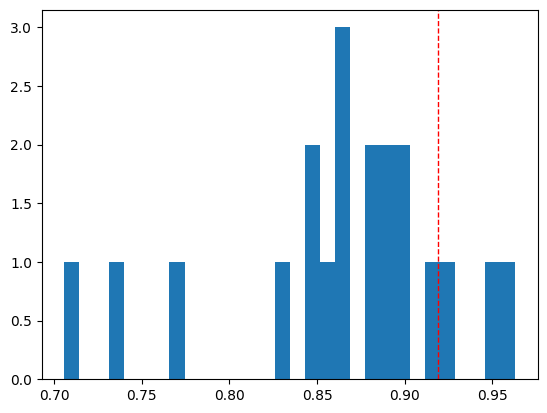

In [72]:
# Logistic Regression per cluster
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split in to train/test
def cluster_logistic_regression(sample_1, tfidf_matrix, c):
    X, y = ((tfidf_matrix.toarray())[sample_1['cluster'] == c]), sample_1[sample_1['cluster'] == c]['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

cluster_scores = np.zeros(n_clusters)
for c in range(n_clusters):
    print(f'cluster {c}')
    # print(f"\nCluster {c} Logistic Regression:")
    X_train, X_test, y_train, y_test = cluster_logistic_regression(sample, tfidf_matrix, c)
    model = LogisticRegression(max_iter=1000)
    try:
        model.fit(X_train, y_train)
        scor = model.score(X_test, y_test)
        cluster_scores[c] = scor
    except Exception as e:
        print('')
        # print(f"  Error training cluster {c}: {e}")

# Train on full dataset
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix.toarray(), sample['label'], test_size=0.2, random_state=42)
full_model = LogisticRegression(max_iter=1000)
full_model.fit(X_train, y_train)
full_score = full_model.score(X_test, y_test)
print(full_score)

print(cluster_scores)

plt.hist(cluster_scores,bins=30)
plt.axvline(full_score, color='red', linestyle='dashed', linewidth=1, label='Full Model Score')

In [73]:
mu, sigma = np.mean(cluster_scores), np.std(cluster_scores)
print(f"Cluster Scores: mean={mu:.3f}, std={sigma:.3f}")

# Calculate if variance of cluster scores is significantly different from full model score using a t-test
from scipy import stats
t_stat, p_value = stats.ttest_1samp(cluster_scores, full_score)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

Cluster Scores: mean=0.864, std=0.064
T-statistic: -3.754, P-value: 0.001


Accuracy: 0.9234256926952141
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1919
           1       0.92      0.94      0.93      2051

    accuracy                           0.92      3970
   macro avg       0.92      0.92      0.92      3970
weighted avg       0.92      0.92      0.92      3970

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
cluster 15
cluster 16
cluster 17
cluster 18
cluster 19
[0.92961877 0.99082569 0.89440994 0.88095238 0.96296296 0.91949153
 0.90849673 0.92207792 0.98181818 0.87968442 0.9375     0.93898305
 0.92957746 0.84       0.84313725 0.98039216 0.85714286 0.91242363
 0.98360656 0.89640884]


Text(0, 0.5, 'Count')

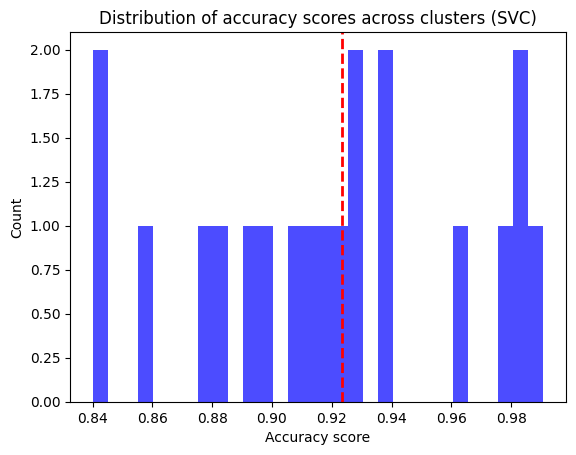

In [77]:
# Do the same with SVC and compare results.
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix.toarray(), sample['label'], test_size=0.2, random_state=42)
svm = LinearSVC(C=1.0)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

full_score = accuracy_score(y_test, y_pred)

# By cluster
def cluster_SVC(sample_1, tfidf_matrix, c):
    X, y = ((tfidf_matrix.toarray())[sample_1['cluster'] == c]), sample_1[sample_1['cluster'] == c]['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

cluster_scores = np.zeros(n_clusters)
for c in range(n_clusters):
    print(f'cluster {c}')
    # print(f"\nCluster {c} Logistic Regression:")
    X_train, X_test, y_train, y_test = cluster_SVC(sample, tfidf_matrix, c)
    model = LinearSVC(C=1.0)
    try:
        model.fit(X_train, y_train)
        scor = model.score(X_test, y_test)
        cluster_scores[c] = scor
    except Exception as e:
        print('')

print(cluster_scores)

plt.hist(cluster_scores,bins=30,color='blue',alpha=0.7)
plt.axvline(full_score, color='red', linestyle='dashed', linewidth=2, label='Full Model Score')
plt.title('Distribution of accuracy scores across clusters (SVC)')
plt.xlabel('Accuracy score')
plt.ylabel('Count')

In [75]:
mu, sigma = np.mean(cluster_scores), np.std(cluster_scores)
print(f"Cluster Scores: mean={mu:.3f}, std={sigma:.3f}")

# Calculate if variance of cluster scores is significantly different from full model score using a t-test
from scipy import stats
t_stat, p_value = stats.ttest_1samp(cluster_scores, full_score)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

Cluster Scores: mean=0.919, std=0.045
T-statistic: -0.385, P-value: 0.705
